In [1]:
%matplotlib inline
import keras
from keras.datasets import mnist

import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Activation, Input, BatchNormalization, Reshape, Dropout, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D, Deconv2D, UpSampling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model
from keras.optimizers import Adam
import keras.backend as K
from IPython import display
import matplotlib.pyplot as plt
import random
import numpy as np
K.set_image_dim_ordering('th')
from PIL import Image
import glob


Using TensorFlow backend.


In [2]:
img_rows, img_cols = 40, 40


In [3]:
# Pokeyman loading code
# Get the image and resize to 3 x 40 x 40
def get_image_array(path, shape):
    img = Image.open(path).convert('RGB')
    img = img.resize(shape)
    return np.array(img).transpose((2, 0, 1))

def get_image_arrays(paths, shape=(img_rows, img_cols)):
    data = np.zeros((len(paths), 3, shape[0], shape[1]))
    for i in range(len(paths)):
        path = paths[i]
        arr = get_image_array(path, shape)
        data[i] = arr
    return data

def load_pokeyman(n=None):
    if n:
        images = glob.glob('pokeyman/**/**/**/*.png')[0:n]
    else:
        images = glob.glob('pokeyman/**/**/**/*.png')
        
    X = get_image_arrays(images)
    return X.astype('float32') / 255.

X_train = load_pokeyman()

In [4]:

print np.min(X_train), np.max(X_train)

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')


0.0 1.0
('X_train shape:', (4732, 3, 40, 40))
(4732, 'train samples')


In [5]:
def make_trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val


In [6]:
shp = X_train.shape[1:]
print shp

dropout_rate = 0.25
# Optim

opt = Adam(lr=1e-4)
dopt = Adam(lr=1e-4)
#opt = Adam(lr=1e-3)
#opt = Adamax(lr=1e-4)
#opt = Adam(lr=0.0002)
#opt = Adam(lr=0.0002, beta_1=0.5, beta_2=0.999, epsilon=1e-08)
nch = 200

# Build Generative model ...
nch = 200
g_input = Input(shape=[100])
H = Dense(nch*20*20, init='glorot_normal')(g_input)
H = BatchNormalization(mode=2)(H)
H = Activation('relu')(H)
H = Reshape( [nch, 20, 20] )(H)
H = UpSampling2D(size=(2, 2))(H)
H = Convolution2D(nch/2, 3, 3, border_mode='same', init='glorot_uniform')(H)
H = BatchNormalization(mode=2)(H)
H = Activation('relu')(H)
H = Convolution2D(nch/4, 3, 3, border_mode='same', init='glorot_uniform')(H)
H = BatchNormalization(mode=2)(H)
H = Activation('relu')(H)
H = Convolution2D(3, 1, 1, border_mode='same', init='glorot_uniform')(H)
g_V = Activation('sigmoid')(H)
generator = Model(g_input,g_V)
generator.compile(loss='binary_crossentropy', optimizer=opt)
generator.summary()


# Build Discriminative model ...
d_input = Input(shape=shp)
H = Convolution2D(256, 5, 5, subsample=(2, 2), border_mode = 'same', activation='relu')(d_input)
H = LeakyReLU(0.2)(H)
H = Dropout(dropout_rate)(H)
H = Convolution2D(512, 5, 5, subsample=(2, 2), border_mode = 'same', activation='relu')(H)
H = LeakyReLU(0.2)(H)
H = Dropout(dropout_rate)(H)
H = Flatten()(H)
H = Dense(256)(H)
H = LeakyReLU(0.2)(H)
H = Dropout(dropout_rate)(H)
d_V = Dense(2,activation='softmax')(H)
discriminator = Model(d_input,d_V)
discriminator.compile(loss='categorical_crossentropy', optimizer=dopt)
discriminator.summary()

# Freeze weights in the discriminator for stacked training
def make_trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val
make_trainable(discriminator, False)
# Build stacked GAN model
gan_input = Input(shape=[100])
H = generator(gan_input)
gan_V = discriminator(H)
GAN = Model(gan_input, gan_V)
GAN.compile(loss='categorical_crossentropy', optimizer=opt)
GAN.summary()


(3, 40, 40)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 100)           0                                            
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 80000)         8080000     input_1[0][0]                    
____________________________________________________________________________________________________
batchnormalization_1 (BatchNorma (None, 80000)         320000      dense_1[0][0]                    
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 80000)         0           batchnormalization_1[0][0]       
_______________________________________________________________________________

In [48]:
def plot_loss(losses):
        display.clear_output(wait=True)
        display.display(plt.gcf())
        plt.figure(figsize=(10,4))
        plt.plot(losses["d"], label='discriminitive loss')
        plt.plot(losses["g"], label='generative loss')
        plt.legend()
        plt.show()


In [24]:
def plot_gen(n_ex=16,dim=(4,4), figsize=(10,10), test=False):
    if test:
        generated_images = X_train[0:n_ex]
    else:
        noise = np.random.uniform(0,1,size=[n_ex,100])
        generated_images = generator.predict(noise)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0],dim[1],i+1)
        img = generated_images[i,:,:,:]
        plt.imshow(img.transpose(1, 2, 0))
        plt.axis('off')
    plt.tight_layout()
    plt.show()

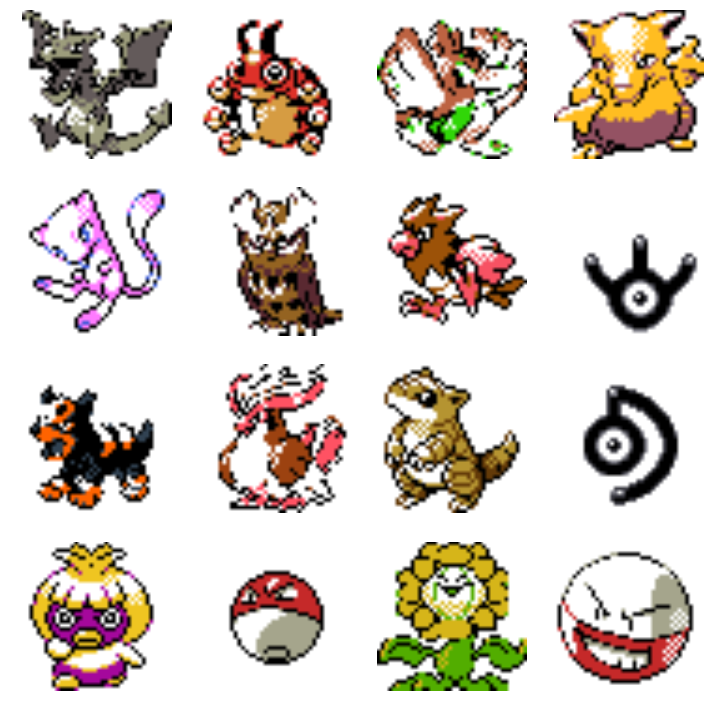

In [25]:
plot_gen(test=True)

In [16]:
ntrain = 1000
trainidx = random.sample(range(0,X_train.shape[0]), ntrain)
XT = X_train[trainidx,:,:,:]

# Pre-train the discriminator network ...
noise_gen = np.random.uniform(0,1,size=[XT.shape[0],100])
generated_images = generator.predict(noise_gen)
X = np.concatenate((XT, generated_images))
n = XT.shape[0]
y = np.zeros([2*n,2])
y[:n,1] = 1
y[n:,0] = 1

make_trainable(discriminator,True)
discriminator.fit(X,y, nb_epoch=1, batch_size=32)
y_hat = discriminator.predict(X)


Epoch 1/1
2000/2000 [==============================] - 4s - loss: 0.1461     


In [17]:
y_hat_idx = np.argmax(y_hat,axis=1)
y_idx = np.argmax(y,axis=1)
diff = y_idx-y_hat_idx
n_tot = y.shape[0]
n_rig = (diff==0).sum()
acc = n_rig*100.0/n_tot
print "Accuracy: %0.02f pct (%d of %d) right"%(acc, n_rig, n_tot)


Accuracy: 99.80 pct (1996 of 2000) right


In [18]:
losses = {"d":[], "g":[]}


In [39]:
from keras.models import load_model
def train_for_n(nb_epoch=5000, plt_frq=25,BATCH_SIZE=32,save_freq=5000):

    for e in range(nb_epoch):  
        
        # Make generative images
        image_batch = X_train[np.random.randint(0,X_train.shape[0],size=BATCH_SIZE),:,:,:]    
        noise_gen = np.random.uniform(0,1,size=[BATCH_SIZE,100])
        generated_images = generator.predict(noise_gen)
        
        # Train discriminator on generated images
        X = np.concatenate((image_batch, generated_images))
        y = np.zeros([2*BATCH_SIZE,2])
        y[0:BATCH_SIZE,1] = 1
        y[BATCH_SIZE:,0] = 1
        
        make_trainable(discriminator,True)
        d_loss  = discriminator.train_on_batch(X,y)
        losses["d"].append(d_loss)
    
        # train Generator-Discriminator stack on input noise to non-generated output class
        noise_tr = np.random.uniform(0,1,size=[BATCH_SIZE,100])
        y2 = np.zeros([BATCH_SIZE,2])
        y2[:,1] = 1
        
        make_trainable(discriminator,False)
        g_loss = GAN.train_on_batch(noise_tr, y2 )
        losses["g"].append(g_loss)
        
        # Updates plots
        if e%plt_frq==plt_frq-1:
            plot_loss(losses)
            plot_gen()
            
        if e%save_freq==save_freq-1:
            generator.save("models/generator-{}.h5".format(e))
            discriminator.save("models/discriminator-{}.h5".format(e))



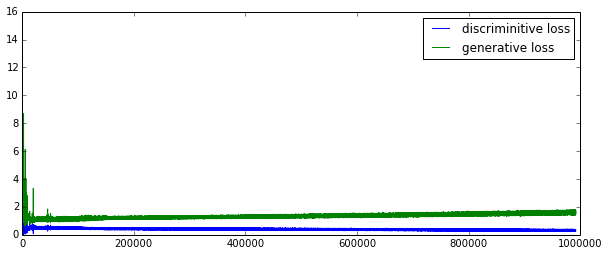

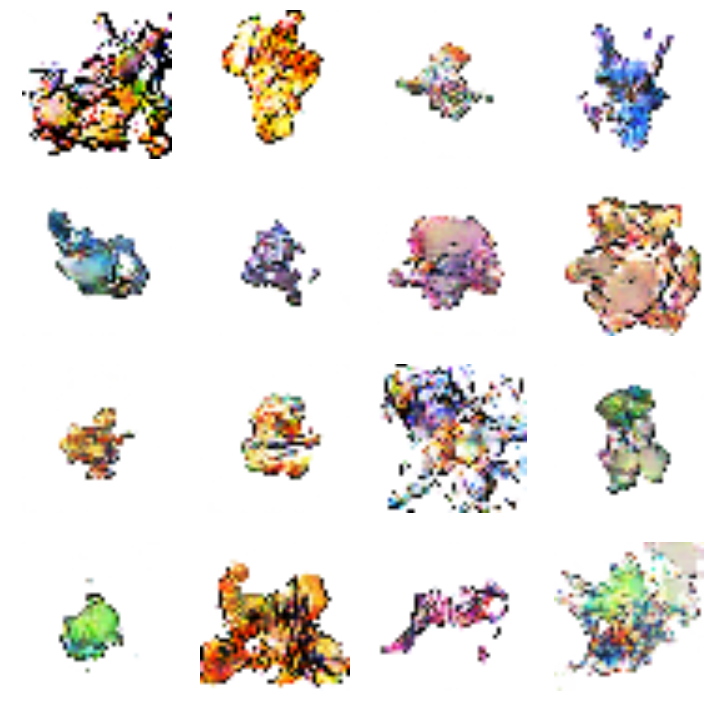

In [ ]:
K.set_value(opt.lr, 1e-6)
K.set_value(dopt.lr, 1e-7)
train_for_n(nb_epoch=5000000, plt_frq=50,BATCH_SIZE=128)
